In [65]:
import os
import shap
import getpass
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from datetime import timedelta, datetime
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K, losses, optimizers, layers, models, utils, callbacks


# Make sure to update the paths in this notebook
This cell below and one of the last cells in Save Preformance needs your local path to your data

## Load Data 🩻

In [66]:
# Update this path
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# Load the train data
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)
[]
# Load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 9032 files belonging to 10 classes.
Using 8129 files for training.
Found 9032 files belonging to 10 classes.
Using 903 files for validation.


## Prepresses Data 🔧

In [67]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [68]:
# Data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [64]:
# Get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    # Append train data to x_train
    x_train.append(images.numpy())

    # Append labels to y_train
    y_train.append(labels.numpy())

# Concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [28]:
# Get val data and labels
x_val = []
y_val = []

for images, labels in val_dataset:
    # Append train data to x_train
    x_val.append(images.numpy())

    # Append labels to y_train
    y_val.append(labels.numpy())

# Concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [29]:
# One-hot encode the train, val data
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

## Initialize Model 🤌



In [30]:
def initialize_model(x_train):

    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same", input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(64, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(256, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=100))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=10, activation="softmax"))

    opt = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    return model

model = initialize_model(x_train)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                      

## Train the Model 💪 

In [31]:
# Save checkpoints to monitor best performing models
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [32]:
# Start timer
start_train_time = datetime.now()

# Train model
history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

# End timer
end_train_time = datetime.now()
train_time = (end_train_time - start_train_time).total_seconds()

254/255 [============================>.] - ETA: 0s - loss: 2.2533 - accuracy: 0.2256

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 113s 439ms/step - loss: 2.2533 - accuracy: 0.2256 - val_loss: 1.8400 - val_accuracy: 0.3654


## Evaluate the Model 🕵️‍♂️

In [70]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

print('Train Loss: ', train_loss)
print('Train Accuracy: ', train_accuracy)
print('Val Loss: ', val_loss)
print('Val Accuracy: ', val_accuracy)

Train Loss:  [2.2532951831817627]
Train Accuracy:  [0.22561199963092804]
Val Loss:  [1.8399962186813354]
Val Accuracy:  [0.22561199963092804]


In [34]:
# Start timer
start_eval_time = datetime.now()

# Evaluate model
model.evaluate(x_val, y_val)

# End timer
end_eval_time = datetime.now()
eval_time = (end_eval_time - start_eval_time).total_seconds()

29/29 [==============================] - 3s 107ms/step - loss: 1.8400 - accuracy: 0.3654


## Plote Learning Curve 📊

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

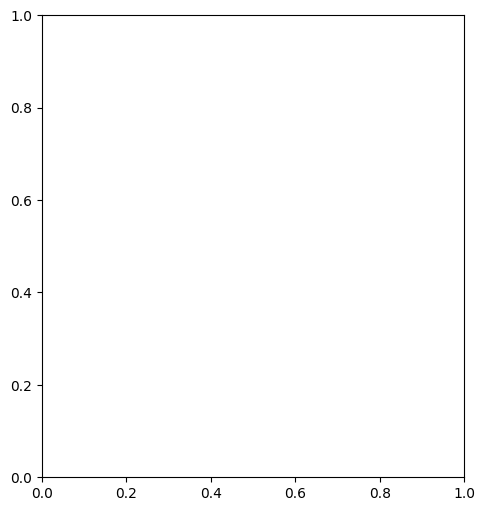

In [58]:
# Plot learning curve
epochs = range(1, 11)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Preformance 🔍

In [ ]:
# Start prediction timer
start_pred_time = datetime.now()

# Get predictions of the model
preds = model.predict(x_val)
CLASSES = np.array(class_names)
predictions = CLASSES[np.argmax(preds, axis=-1)]
y_val_classes = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_pred_time = datetime.now()
pred_time = (end_pred_time - start_pred_time).total_seconds()

29/29 [==============================] - 3s 89ms/step


In [ ]:
# Calculate accuracy, precision, recall, f1
accuracy = accuracy_score(predictions, y_val_classes)
precision = precision_score(predictions, y_val_classes, average='weighted')
recall = recall_score(predictions, y_val_classes, average='weighted')
f1 = f1_score(predictions, y_val_classes, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9568106312292359
Precision: 0.9575464008363052
Recall: 0.9568106312292359
F1 Score: 0.956908014682492


## Save Preformance to CSV 📝

In [36]:
def log_model_metrics(metrics_file, csv_file, model_name, train_time, eval_time, pred_one_time):

    # Load metrics generated by train_eval.py
    metrics_df = pd.read_csv(metrics_file, header=None, names=["value"])
    accuracy = float(metrics_df.iloc[0].value)
    precision = float(metrics_df.iloc[1].value)
    recall = float(metrics_df.iloc[2].value)
    f1 = float(metrics_df.iloc[3].value)

    # Log results to DataFrame
    columns = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]
    name = getpass.getuser()  # Get the username of the person running the script

    # Create a DataFrame to hold the new data
    data = {
        "name": [name],
        "model": [model_name],
        "train_time": [train_time],
        "eval_time": [eval_time],
        "pred_one_time": [pred_one_time],
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1]
    }
    df_new = pd.DataFrame(data)

    # Check if the file exists
    if os.path.exists(csv_file):
        # If the file exists, append the new data
        df_existing = pd.read_csv(csv_file)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        # If the file does not exist, the new data is the combined data
        df_combined = df_new

    # Save the combined data to the CSV file
    df_combined.to_csv(csv_file, index=False)


In [37]:
def preprocess_single_image(img_path, target_size=(256, 256)):
    """
    Load and preprocess a single image
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

In [38]:
def predict_single_image(model, img_array, class_names_dict):
    """
    Make a prediction on a single image
    """
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=-1)
    class_name = class_names_dict[predicted_class[0]]
    return class_name

In [39]:
# Update this path to any single image
img_path = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification/Avulsion fracture/Train/94f6a-pclavulsion1a_png.rf.621b9fb0ecda5666f169e06b88d35b9e.jpg"

# Preprocess a single image
img_array = preprocess_single_image(img_path)

class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

1/1 [==============================] - 0s 226ms/step
Predicted class: Avulsion fracture


Predict One Image

In [40]:
# Start single image prediction timer
start_pred_one_time = datetime.now()

# Predict one image
predicted_class_name = predict_single_image(model, img_array, class_names_dict)
print("Predicted class:", predicted_class_name)

# End timer
end_pred_one_time = datetime.now()
pred_one_time = (end_pred_one_time - start_pred_one_time).total_seconds()

1/1 [==============================] - 0s 22ms/step
Predicted class: Avulsion fracture


In [41]:
# Run log model metrics function
log_model_metrics("metrics.txt", "results.csv", "Original-CNN-Kaggle", train_time, eval_time, pred_one_time)

## Examine Data 📊

In [42]:
# Read the results csv
res = pd.read_csv('/Users/owenclary/code/Owencclary/x_ray_lewagon2024/notebooks/results.csv')

res

,name,model,train_time,eval_time,pred_one_time,accuracy,precision,recall,f1
0,owenclary,Original-CNN-Kaggle,6960.186786,2.395517,0.045547,0.956811,0.957546,0.956811,0.956908
1,owenclary,Original-CNN-Kaggle,112.976097,3.232416,0.064276,0.956811,0.957546,0.956811,0.956908


## Shapley  🚀


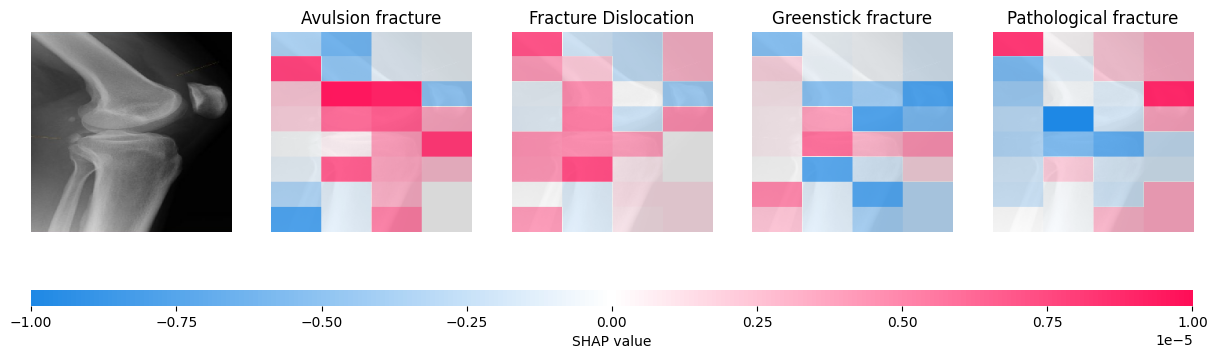

In [57]:
# Masker that will mask out partitions of the input image
masker = shap.maskers.Image("blur(128,128)", img_array[0].shape)

# Create the explainer
explainer = shap.Explainer(model, masker, output_names=list(class_names_dict.values()))

# Explain the single image to estimate SHAP values
shap_values = explainer(img_array, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# Show the plot
shap.image_plot(shap_values, pixel_values=img_array)